In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import precision_recall_curve,  plot_precision_recall_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score 

In [3]:
data = pd.read_csv("Fake News Detection.csv")
data.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20800 non-null  int64 
 1   headline    20242 non-null  object
 2   written_by  18843 non-null  object
 3   news        20761 non-null  object
 4   label       20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 975.0+ KB


In [5]:
data.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [6]:
data.isna().sum()

id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64

In [7]:
data['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

Text(0.5, 1.0, 'Frequency of Both labels ')

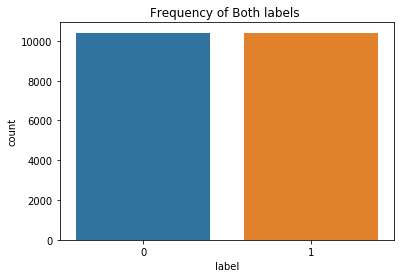

In [8]:
sns.countplot(data.label)
plt.title('Frequency of Both labels ')

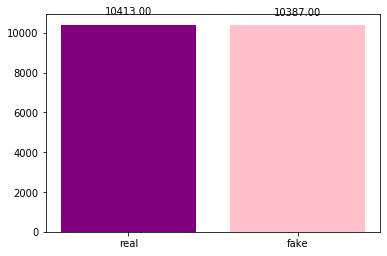

In [9]:
values = data['label'].value_counts()
plt.bar(x=["real", "fake"], height=values, color=["purple", "pink"])
for x,y in zip(["real", "fake"],values):

    label = "{:.2f}".format(y)

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
plt.show()

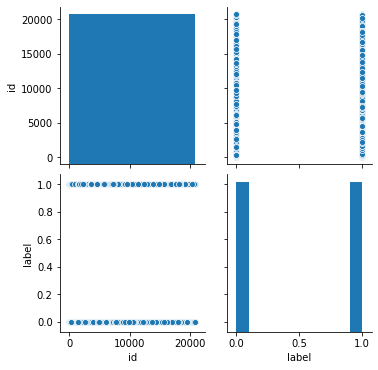

In [10]:
sns.pairplot(data)

In [11]:
df_reliable = data.loc[data['label'] == 1]
df_reliable.head()

,id,headline,written_by,news,label
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1
5,3196,Whatever the Outcome on November 8th the US Wi...,NaN,Taming the corporate media beast Whatever the ...,1
7,1504,Alabama Prison Officials Retaliate Against Pri...,Brian Sonenstein,Advocates say prison officials at the Kilby Co...,1
8,13559,NaN,steventexas,People have made up their minds on president.\...,1
9,4203,Can We Live in a Constant State of Love?,Gillian,Leave a reply \nToni Emerson – When we fall in...,1


In [12]:
df_fake = data.loc[data['label'] == 0]
df_fake.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
6,5134,Rapid Evolution Saved This Fish From Pollution...,JoAnna Klein,The State of New Jersey says you can’t eat the...,0


In [13]:
data.groupby('label')['written_by'].nunique()

label
0    2225
1    1981
Name: written_by, dtype: int64

In [14]:
df_reliable['written_by'].value_counts()

admin                  193
Pakalert                86
Eddy Lavine             85
Starkman                84
Alex Ansary             82
                      ... 
tz1                      1
Fred Tyrell              1
Eligio Abellera          1
Sami Jamil Jadallah      1
Dennis   Kucinich        1
Name: written_by, Length: 1981, dtype: int64

In [15]:
df_fake['written_by'].value_counts()

Pam Key                                                                            242
Jerome Hudson                                                                      166
Charlie Spiering                                                                   141
John Hayward                                                                       140
Katherine Rodriguez                                                                124
                                                                                  ... 
Ismail Khan                                                                          1
Michael Barbaro, Amy Chozick, Patrick Healy, Alan Rappeport and David E. Sanger      1
Katie Thomas and Reed Abelson                                                        1
Joanna Nikas and Valeriya Safronova                                                  1
Jeremy W. Peters and Rachel Shorey                                                   1
Name: written_by, Length: 2225, dtype: int6

In [16]:
data['article'] = data['headline'] + ' ' + data['news']
data.drop(columns=['headline', 'news'], inplace = True)
data.head()

,id,written_by,label,article
0,9653,Eric Lipton and Steve Eder,0,Ethics Questions Dogged Agriculture Nominee as...
1,10041,David Waldstein,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...
2,19113,Pam Key,0,Cotton to House: ’Do Not Walk the Plank and Vo...
3,6868,Jess Bidgood,0,"Paul LePage, Besieged Maine Governor, Sends Co..."
4,7596,Finian Cunningham,1,A Digital 9/11 If Trump Wins Finian Cunningh...


In [17]:
def preprocessArticle(article):
    cleaned_sentence = re.sub(r'[^\w\s]', '', str(article).lower())
    
    words = nltk.word_tokenize(cleaned_sentence)
    
    filtered_words = [word for word in words if not word in stop_words and len(word) > 3]
    output_sentence = ''
    for word in filtered_words:
        output_sentence = output_sentence  + ' ' + str(lemmatizer.lemmatize(word))
    
    return output_sentence

In [18]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [19]:
for index, row in data.iterrows():
    cleaned_sentence = preprocessArticle(str(row['article']))
    data.loc[index, 'cleaned_article'] = cleaned_sentence

data.head()

,id,written_by,label,article,cleaned_article
0,9653,Eric Lipton and Steve Eder,0,Ethics Questions Dogged Agriculture Nominee as...,ethic question dogged agriculture nominee geo...
1,10041,David Waldstein,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,must deep stop argentina lionel messi york ti...
2,19113,Pam Key,0,Cotton to House: ’Do Not Walk the Plank and Vo...,cotton house walk plank vote bill pas senate ...
3,6868,Jess Bidgood,0,"Paul LePage, Besieged Maine Governor, Sends Co...",paul lepage besieged maine governor sends con...
4,7596,Finian Cunningham,1,A Digital 9/11 If Trump Wins Finian Cunningh...,digital trump win finian cunningham written e...


In [20]:
df_reliable = data.loc[data['label'] == 1]
df_fake = data.loc[data['label'] == 0]

cleaned_reliable_articles = list(df_reliable['cleaned_article'])
cleaned_fake_articles = list(df_fake['cleaned_article'])

sentimentAnalyzer = SentimentIntensityAnalyzer()

sentimentscores = []
for i in cleaned_reliable_articles:
    score = sentimentAnalyzer.polarity_scores(i)
    score['article'] = i
    sentimentscores.append(score)
    
sentimentdf_reliable = pd.DataFrame(sentimentscores)

sentimentscores = []
for i in cleaned_fake_articles:
    score = sentimentAnalyzer.polarity_scores(i)
    score['article'] = i
    sentimentscores.append(score)
    
sentimentdf_fake = pd.DataFrame(sentimentscores)

In [21]:
sentimentdf_reliable.head()

,neg,neu,pos,compound,article
0,0.145,0.748,0.107,-0.9906,digital trump win finian cunningham written e...
1,0.122,0.674,0.203,0.9989,whatever outcome november collision course ch...
2,0.237,0.706,0.057,-0.9987,alabama prison official retaliate prison stri...
3,0.000,0.000,0.000,0.0000,
4,0.049,0.428,0.523,0.9999,live constant state love leave reply toni eme...


In [22]:
sentimentdf_fake.head()

,neg,neu,pos,compound,article
0,0.088,0.751,0.160,0.9944,ethic question dogged agriculture nominee geo...
1,0.071,0.637,0.293,0.9993,must deep stop argentina lionel messi york ti...
2,0.048,0.952,0.000,-0.2732,cotton house walk plank vote bill pas senate ...
3,0.131,0.742,0.126,-0.8840,paul lepage besieged maine governor sends con...
4,0.050,0.778,0.172,0.9926,rapid evolution saved fish pollution study sa...


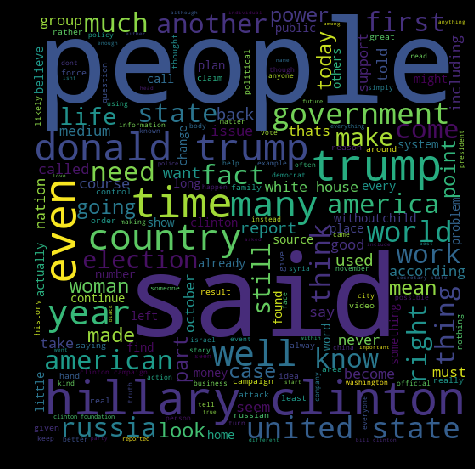

In [23]:
reliable_news = ' '.join(list(data[data['label'] == 1]['cleaned_article']))
reliablenews_wc = WordCloud(width = 512,height = 512).generate(reliable_news)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(reliablenews_wc)
plt.show()

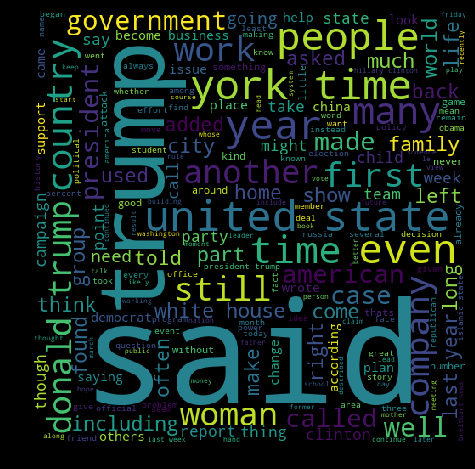

In [24]:
fake_news = ' '.join(list(data[data['label'] == 0]['cleaned_article']))
fakenews_wc = WordCloud(width = 512,height = 512).generate(fake_news)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(fakenews_wc)
plt.show()

In [25]:
sentimentdf_reliable.drop(columns=['article'], inplace = True)
average_sentiment_reliable = sentimentdf_reliable.mean()

sentimentdf_fake.drop(columns=['article'], inplace = True)
average_sentiment_fake = sentimentdf_fake.mean()


Sentiment_analysis..



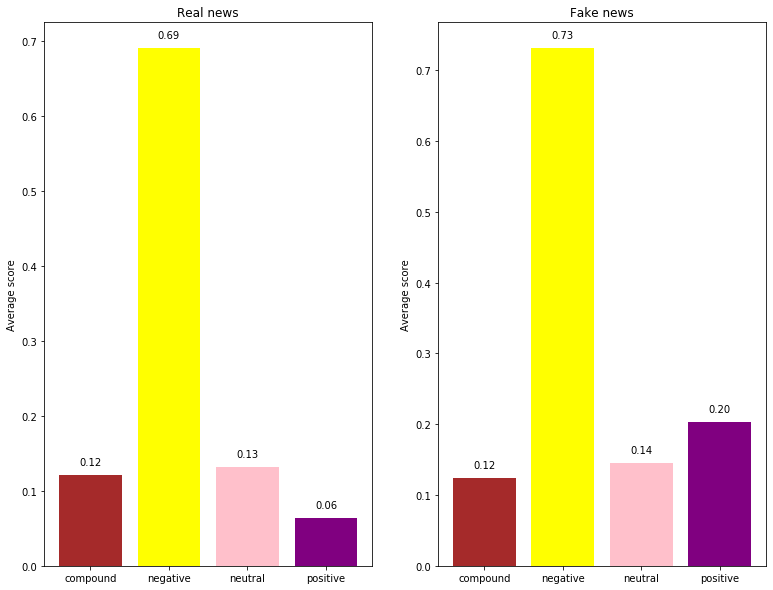

In [26]:
print("\nSentiment_analysis..\n")
names = ['compound', 'negative', 'neutral','positive']
colors=["brown", "yellow", "pink" , "purple"]

plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.bar(names,average_sentiment_reliable, color=colors)
plt.title("Real news")
plt.ylabel("Average score")

for x,y in zip(names,average_sentiment_reliable):

    label = "{:.2f}".format(y)

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
plt.subplot(132)
plt.bar(names,average_sentiment_fake, color=colors)
plt.title("Fake news")
plt.ylabel("Average score")
for x,y in zip(names,average_sentiment_fake):

    label = "{:.2f}".format(y)

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.show()

In [27]:
x = data['cleaned_article']
y = data['label']

In [28]:
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1))
count_vectorizer.fit(x)
unigram_term_freq_matrix = count_vectorizer.transform(x)
print("\nunigram_term_freq_matrix:")
print(unigram_term_freq_matrix)


unigram_term_freq_matrix:
  (0, 2484)	1
  (0, 2687)	4
  (0, 2702)	2
  (0, 2710)	1
  (0, 2721)	1
  (0, 2789)	1
  (0, 2803)	1
  (0, 6879)	1
  (0, 6947)	1
  (0, 6965)	2
  (0, 7322)	1
  (0, 7338)	1
  (0, 7341)	2
  (0, 7611)	1
  (0, 8212)	1
  (0, 8490)	1
  (0, 8721)	3
  (0, 9024)	1
  (0, 10326)	1
  (0, 10329)	1
  (0, 10727)	4
  (0, 10863)	1
  (0, 11274)	2
  (0, 11517)	1
  (0, 13633)	1
  :	:
  (20799, 134720)	1
  (20799, 139169)	1
  (20799, 142874)	1
  (20799, 143351)	1
  (20799, 143897)	1
  (20799, 144254)	1
  (20799, 144444)	1
  (20799, 145824)	17
  (20799, 145856)	2
  (20799, 149729)	1
  (20799, 149730)	1
  (20799, 155600)	2
  (20799, 156107)	1
  (20799, 156278)	1
  (20799, 157422)	2
  (20799, 157635)	8
  (20799, 158161)	7
  (20799, 164200)	1
  (20799, 164473)	2
  (20799, 166160)	1
  (20799, 166245)	2
  (20799, 166737)	2
  (20799, 167155)	1
  (20799, 167203)	2
  (20799, 168122)	1


In [29]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(unigram_term_freq_matrix)
unigram_tfidf_matrix = tfidf_transformer.transform(unigram_term_freq_matrix)
print("\nunigram_tfidf_matrix:")
print(unigram_tfidf_matrix)


unigram_tfidf_matrix:
  (0, 169680)	0.03601537472447321
  (0, 168543)	0.0071131472863862405
  (0, 168122)	0.024273816103934653
  (0, 168021)	0.03749879245260751
  (0, 167172)	0.02692279420633635
  (0, 166992)	0.005927774195293788
  (0, 166965)	0.027616088952980438
  (0, 166765)	0.010378763286021001
  (0, 166748)	0.03615928732979866
  (0, 166737)	0.00827100114442184
  (0, 164136)	0.024597396960364316
  (0, 163806)	0.012197215174009682
  (0, 163710)	0.019348042501807803
  (0, 163148)	0.015035666991660026
  (0, 161896)	0.015601607974759178
  (0, 161891)	0.03683929212380537
  (0, 161684)	0.0324269537405345
  (0, 161338)	0.028563323486048692
  (0, 161158)	0.01399007109803234
  (0, 160753)	0.018796287207122404
  (0, 160102)	0.012936828946237506
  (0, 159492)	0.010777256351897696
  (0, 158871)	0.016216552258180483
  (0, 158161)	0.021739008551120747
  (0, 155318)	0.029846174170169458
  :	:
  (20799, 37060)	0.017477136783289982
  (20799, 33912)	0.037066943068536355
  (20799, 33641)	0.041756251

In [30]:
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
count_vectorizer.fit(x)
bigram_term_freq_matrix = count_vectorizer.transform(x)
print("\nbigram_term_freq_matrix:")
print(bigram_term_freq_matrix)


bigram_term_freq_matrix:
  (0, 17481)	1
  (0, 17867)	1
  (0, 22198)	4
  (0, 22341)	1
  (0, 22358)	1
  (0, 22562)	1
  (0, 22599)	1
  (0, 22662)	2
  (0, 22894)	1
  (0, 22978)	1
  (0, 23110)	1
  (0, 23179)	1
  (0, 23587)	1
  (0, 23822)	1
  (0, 26375)	1
  (0, 27030)	1
  (0, 27288)	1
  (0, 27482)	1
  (0, 66435)	1
  (0, 66619)	1
  (0, 70599)	1
  (0, 70664)	1
  (0, 71733)	2
  (0, 71751)	1
  (0, 72431)	1
  :	:
  (20799, 3975383)	7
  (20799, 3975413)	1
  (20799, 3975529)	1
  (20799, 3975738)	1
  (20799, 3975935)	1
  (20799, 3976594)	1
  (20799, 3976892)	1
  (20799, 3977160)	1
  (20799, 4110545)	1
  (20799, 4111660)	1
  (20799, 4122909)	2
  (20799, 4123014)	2
  (20799, 4165346)	1
  (20799, 4165382)	1
  (20799, 4168625)	2
  (20799, 4169153)	2
  (20799, 4184095)	2
  (20799, 4187619)	2
  (20799, 4215115)	1
  (20799, 4215288)	1
  (20799, 4219226)	2
  (20799, 4219304)	1
  (20799, 4219589)	1
  (20799, 4226398)	1
  (20799, 4233898)	1


In [31]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(bigram_term_freq_matrix)
bigram_tfidf_matrix = tfidf_transformer.transform(bigram_term_freq_matrix)
print("\nbigram_tfidf_matrix:")
print(bigram_tfidf_matrix)


bigram_tfidf_matrix:
  (0, 4251589)	0.027418890886515706
  (0, 4251588)	0.026334224790180945
  (0, 4240224)	0.005560806830482536
  (0, 4238524)	0.005201090396487627
  (0, 4233299)	0.02221335600080867
  (0, 4229552)	0.04571698483407944
  (0, 4228800)	0.026334224790180945
  (0, 4226398)	0.017748867940062207
  (0, 4225644)	0.027418890886515706
  (0, 4225643)	0.027418890886515706
  (0, 4217503)	0.0369150194106004
  (0, 4216699)	0.019685784752578685
  (0, 4205538)	0.018973549340572837
  (0, 4204363)	0.004334352741253725
  (0, 4203354)	0.027418890886515706
  (0, 4203328)	0.025564641947485322
  (0, 4203252)	0.02019271769007137
  (0, 4192467)	0.018862070054132016
  (0, 4191702)	0.007588889120524119
  (0, 4189163)	0.024067604939839053
  (0, 4188733)	0.026334224790180945
  (0, 4188413)	0.024067604939839053
  (0, 4188249)	0.026439452819259468
  (0, 4187478)	0.026334224790180945
  (0, 4184095)	0.00604770615447857
  :	:
  (20799, 325618)	0.02493717650586175
  (20799, 317375)	0.04556176287008165
  

In [32]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3))
tfidf_vectorizer.fit(x)
trigram_tfidf_matrix = tfidf_vectorizer.transform(x)
print("\ntrigram_tfidf_matrix:")
print(trigram_tfidf_matrix)


trigram_tfidf_matrix:
  (0, 11088800)	0.022322171363867657
  (0, 11088799)	0.022322171363867657
  (0, 11088798)	0.021439126802540447
  (0, 11059553)	0.009356865488034006
  (0, 11056692)	0.004527144569966624
  (0, 11050950)	0.0042342934872854265
  (0, 11036636)	0.020812596715512294
  (0, 11036631)	0.01808425954459385
  (0, 11019943)	0.022322171363867657
  (0, 11019938)	0.022322171363867657
  (0, 11019933)	0.0372189514860184
  (0, 11016535)	0.022322171363867657
  (0, 11016534)	0.021439126802540447
  (0, 11006535)	0.01444964616958918
  (0, 11004866)	0.022322171363867657
  (0, 11004865)	0.022322171363867657
  (0, 11004864)	0.022322171363867657
  (0, 10985190)	0.021439126802540447
  (0, 10985188)	0.021439126802540447
  (0, 10985155)	0.030053126240389548
  (0, 10983133)	0.016026522097412073
  (0, 10938938)	0.022322171363867657
  (0, 10938915)	0.015446679499693134
  (0, 10931531)	0.0035286680647354986
  (0, 10928926)	0.022322171363867657
  :	:
  (20799, 473262)	0.014477569846939977
  (20799,

In [33]:
train_x_unigram_tf, test_x_unigram_tf, train_y_unigram_tf, test_y_unigram_tf = train_test_split(unigram_term_freq_matrix, y)

In [34]:
train_x_unigram_tfidf, test_x_unigram_tfidf, train_y_unigram_tfidf, test_y_unigram_tfidf = train_test_split(unigram_tfidf_matrix, y)

In [35]:
train_x_bigram_tf, test_x_bigram_tf, train_y_bigram_tf, test_y_bigram_tf = train_test_split(bigram_term_freq_matrix, y)

In [36]:
train_x_bigram_tfidf, test_x_bigram_tfidf, train_y_bigram_tfidf, test_y_bigram_tfidf = train_test_split(bigram_tfidf_matrix, y)

In [37]:
train_x_trigram_tfidf, test_x_trigram_tfidf, train_y_trigram_tfidf, test_y_trigram_tfidf = train_test_split(trigram_tfidf_matrix, y)

In [38]:
metrics = {}
attributes = ["accuracy", "precision(macro)", "precision(micro)", "recall(macro)", "recall(micro)", "f1_score(macro)", "f1_score(micro)"]

In [39]:
def assess_model_performance(classifier_model, test_x, test_y, name):
    true_y = test_y
    pred_y = classifier_model.predict(test_x)
    
    accuracy = "%0.2f" % (classifier_model.score(test_x, true_y)*100) + "%"
    precision_macro = "%0.3f" % (precision_score(true_y, pred_y, average='macro'))
    precision_micro = "%0.3f" % (precision_score(true_y, pred_y, average='micro'))
    recall_macro = "%0.3f" %(recall_score(true_y, pred_y, average='macro'))
    recall_micro = "%0.3f" %(recall_score(true_y, pred_y, average='micro'))
    f1_macro = "%0.3f" %(f1_score(true_y, pred_y, average='macro'))
    f1_micro = "%0.3f" %(f1_score(true_y, pred_y, average='micro'))
    print("Accuracy: " + accuracy)
    print("Precision (macro): " + precision_macro)
    print("Precision (micro): " + precision_micro)
    print("Recall (macro): " + recall_macro)
    print("Recall (micro): " + recall_micro)
    print("F1Score (macro): " + f1_macro)
    print("F1Score (micro): " + f1_micro)
    
    metrics[name] = pd.Series([accuracy, precision_macro, precision_micro, 
    recall_macro, recall_micro, f1_macro, f1_micro], index=attributes)
    
    plot_confusion_matrix(classifier_model, test_x, true_y, display_labels=['RELIABLE', 'FAKE'], values_format="d")
    disp = plot_precision_recall_curve(classifier_model, test_x, true_y)
    disp.ax_.set_title('Precision-Recall curve')                           

MultinomialNB


With smoothing, using unigram term frequency counts:
Accuracy: 90.25%
Precision (macro): 0.911
Precision (micro): 0.902
Recall (macro): 0.901
Recall (micro): 0.902
F1Score (macro): 0.902
F1Score (micro): 0.902


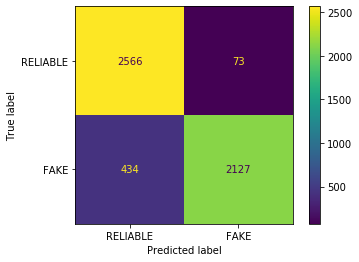

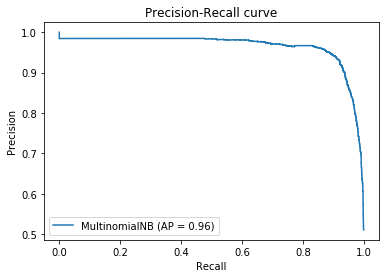

In [40]:
print("\nWith smoothing, using unigram term frequency counts:")
mnb_smoothing_unigram_tf = MultinomialNB(alpha=1.0)
mnb_smoothing_unigram_tf.fit(train_x_unigram_tf, train_y_unigram_tf)
assess_model_performance(mnb_smoothing_unigram_tf, test_x_unigram_tf, test_y_unigram_tf, "Multinomial naive bayes (TF/Unigram/Smoothing)")


With smoothing, using unigram and bigram tf-idf:
Accuracy: 80.29%
Precision (macro): 0.857
Precision (micro): 0.803
Recall (macro): 0.802
Recall (micro): 0.803
F1Score (macro): 0.795
F1Score (micro): 0.803


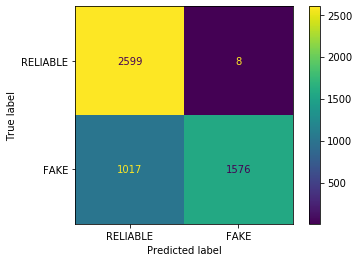

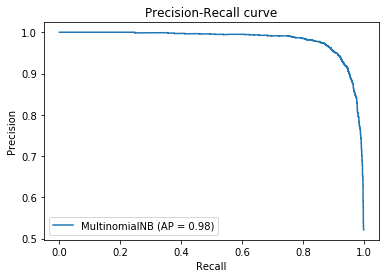

In [41]:
print("\nWith smoothing, using unigram and bigram tf-idf:")
mnb_smoothing_bigram_tfidf = MultinomialNB(alpha=1.0)
mnb_smoothing_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(mnb_smoothing_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf, "Multinomial naive bayes (TFIDF/Uni-bigram/Smoothing)")


With smoothing, using unigram, bigram and trigram tf-idf:
Accuracy: 81.90%
Precision (macro): 0.866
Precision (micro): 0.819
Recall (macro): 0.818
Recall (micro): 0.819
F1Score (macro): 0.813
F1Score (micro): 0.819


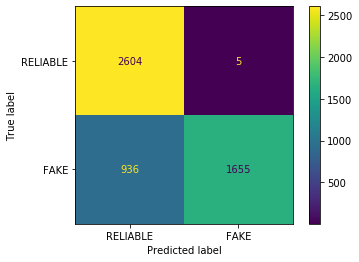

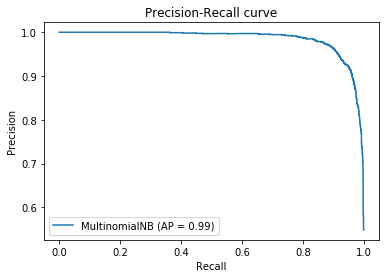

In [42]:
print("\nWith smoothing, using unigram, bigram and trigram tf-idf:")
mnb_smoothing_trigram_tfidf = MultinomialNB(alpha=1.0)
mnb_smoothing_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(mnb_smoothing_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf, "Multinomial naive bayes (TFIDF/Uni-bi-trigram/Smoothing)")

Logistic Regression


Using unigram tf-idf:
Accuracy: 94.46%
Precision (macro): 0.945
Precision (micro): 0.945
Recall (macro): 0.945
Recall (micro): 0.945
F1Score (macro): 0.945
F1Score (micro): 0.945


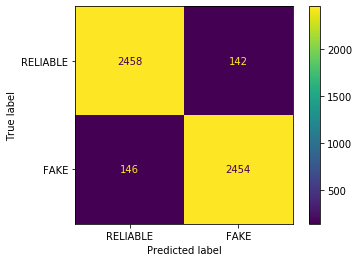

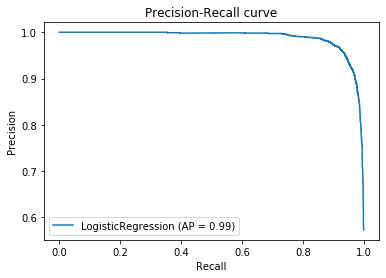

In [43]:
print("\nUsing unigram tf-idf:")
log_reg_unigram_tfidf = LogisticRegression()
log_reg_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(log_reg_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf, "Logistic Regression (TFIDF/Unigram)")


Using unigram and bigram tf-idf:
Accuracy: 93.90%
Precision (macro): 0.939
Precision (micro): 0.939
Recall (macro): 0.939
Recall (micro): 0.939
F1Score (macro): 0.939
F1Score (micro): 0.939


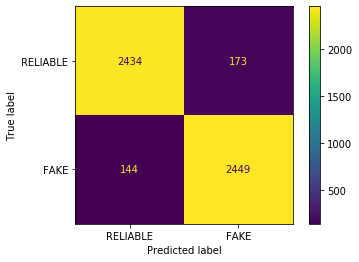

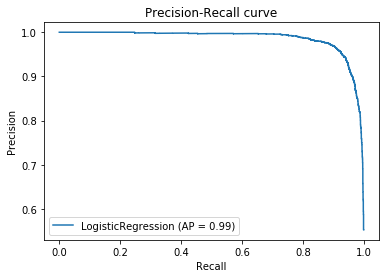

In [44]:
print("\nUsing unigram and bigram tf-idf:")
log_reg_bigram_tfidf = LogisticRegression()
log_reg_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(log_reg_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf, "Logistic Regression (TFIDF/Uni-bigram)")


Using unigram, bigram, trigram tf-idf:
Accuracy: 93.90%
Precision (macro): 0.939
Precision (micro): 0.939
Recall (macro): 0.939
Recall (micro): 0.939
F1Score (macro): 0.939
F1Score (micro): 0.939


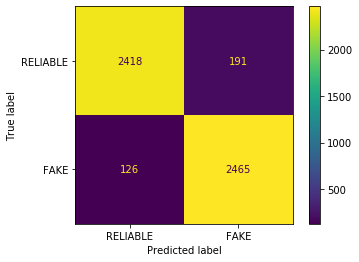

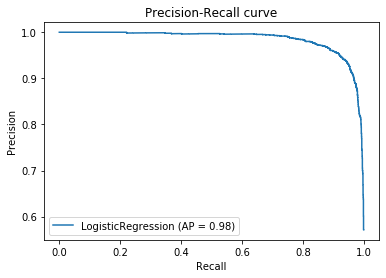

In [45]:
print("\nUsing unigram, bigram, trigram tf-idf:")
log_reg_trigram_tfidf = LogisticRegression()
log_reg_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(log_reg_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf, "Logistic Regression (TFIDF/Uni-bi-trigram)")

Linear SVC


With linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram tf-idf:
Accuracy: 95.98%
Precision (macro): 0.960
Precision (micro): 0.960
Recall (macro): 0.960
Recall (micro): 0.960
F1Score (macro): 0.960
F1Score (micro): 0.960


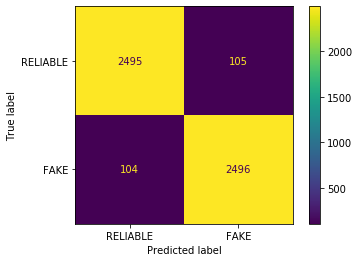

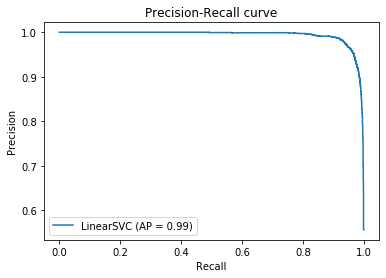

In [46]:
print("\nWith linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram tf-idf:")

linear_svc_c1_unigram_tfidf = LinearSVC(C=1.0, max_iter=1000)
linear_svc_c1_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(linear_svc_c1_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf, "Linear SVC (TFIDF/Unigram)")


With linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram and bigram tf-idf:
Accuracy: 96.04%
Precision (macro): 0.960
Precision (micro): 0.960
Recall (macro): 0.960
Recall (micro): 0.960
F1Score (macro): 0.960
F1Score (micro): 0.960


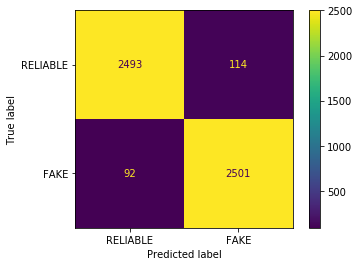

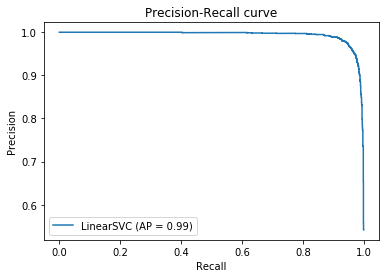

In [47]:
print("\nWith linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram and bigram tf-idf:")

linear_svc_c1_bigram_tfidf = LinearSVC(C=1.0, max_iter=1000)
linear_svc_c1_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(linear_svc_c1_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf, "Linear SVC (TFIDF/Uni-bigram)")


With linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram, bigram and trigram tf-idf:
Accuracy: 96.10%
Precision (macro): 0.961
Precision (micro): 0.961
Recall (macro): 0.961
Recall (micro): 0.961
F1Score (macro): 0.961
F1Score (micro): 0.961


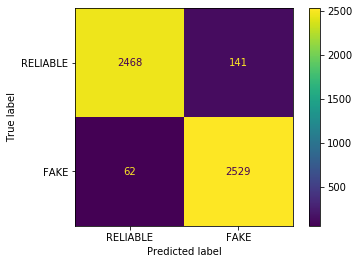

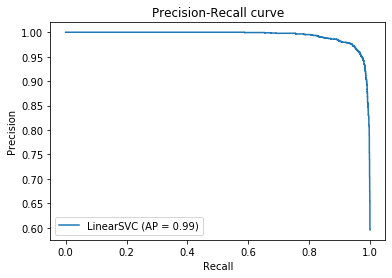

In [48]:
print("\nWith linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram, bigram and trigram tf-idf:")

linear_svc_c1_trigram_tfidf = LinearSVC(C=1.0, max_iter=1000)
linear_svc_c1_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(linear_svc_c1_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf, "Linear SVC (TFIDF/Uni-bi-trigram)")

Decision Tree


Using unigram tf-idf:
Accuracy: 93.44%
Precision (macro): 0.934
Precision (micro): 0.934
Recall (macro): 0.934
Recall (micro): 0.934
F1Score (macro): 0.934
F1Score (micro): 0.934


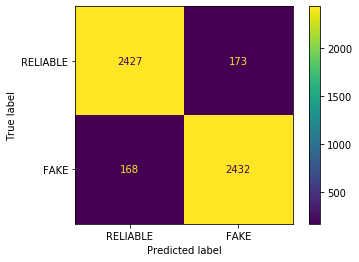

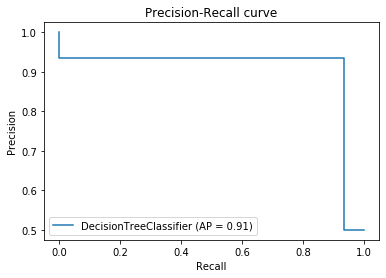

In [49]:
print("\nUsing unigram tf-idf:")
dtree_unigram_tfidf = DecisionTreeClassifier()
dtree_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(dtree_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf, "Decision Tree (TFIDF/Unigram)")


Using unigram and bigram tf-idf:
Accuracy: 95.33%
Precision (macro): 0.953
Precision (micro): 0.953
Recall (macro): 0.953
Recall (micro): 0.953
F1Score (macro): 0.953
F1Score (micro): 0.953


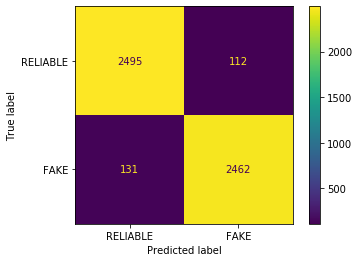

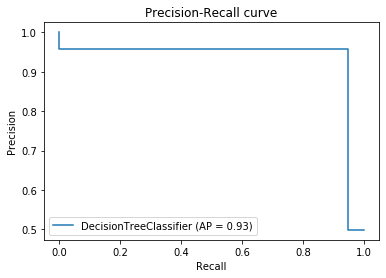

In [50]:
print("\nUsing unigram and bigram tf-idf:")
dtree_bigram_tfidf = DecisionTreeClassifier()
dtree_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(dtree_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf, "Decision Tree (TFIDF/Uni-bigram)")


Using unigram, bigram, trigram tf-idf:
Accuracy: 96.15%
Precision (macro): 0.962
Precision (micro): 0.962
Recall (macro): 0.962
Recall (micro): 0.962
F1Score (macro): 0.962
F1Score (micro): 0.962


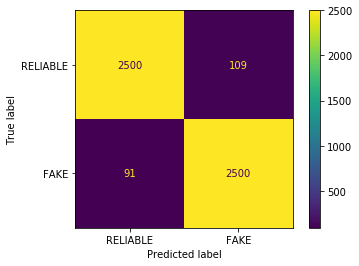

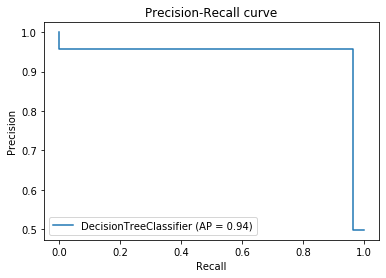

In [51]:
print("\nUsing unigram, bigram, trigram tf-idf:")
dtree_trigram_tfidf = DecisionTreeClassifier()
dtree_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(dtree_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf, "Decision Tree (TFIDF/Uni-bi-trigram)")

In [52]:
df_metrics = pd.DataFrame(metrics)
df_metrics.transpose()

,accuracy,precision(macro),precision(micro),recall(macro),recall(micro),f1_score(macro),f1_score(micro)
Multinomial naive bayes (TF/Unigram/Smoothing),90.25%,0.911,0.902,0.901,0.902,0.902,0.902
Multinomial naive bayes (TFIDF/Uni-bigram/Smoothing),80.29%,0.857,0.803,0.802,0.803,0.795,0.803
Multinomial naive bayes (TFIDF/Uni-bi-trigram/Smoothing),81.90%,0.866,0.819,0.818,0.819,0.813,0.819
Logistic Regression (TFIDF/Unigram),94.46%,0.945,0.945,0.945,0.945,0.945,0.945
Logistic Regression (TFIDF/Uni-bigram),93.90%,0.939,0.939,0.939,0.939,0.939,0.939
Logistic Regression (TFIDF/Uni-bi-trigram),93.90%,0.939,0.939,0.939,0.939,0.939,0.939
Linear SVC (TFIDF/Unigram),95.98%,0.960,0.960,0.960,0.960,0.960,0.960
Linear SVC (TFIDF/Uni-bigram),96.04%,0.960,0.960,0.960,0.960,0.960,0.960
Linear SVC (TFIDF/Uni-bi-trigram),96.10%,0.961,0.961,0.961,0.961,0.961,0.961
Decision Tree (TFIDF/Unigram),93.44%,0.934,0.934,0.934,0.934,0.934,0.934
